# 4. Fragmentação de partidos em comunidades

Nesta seção final vamos fazer mais uma análise sobre os dados levantados.

## 4.1. Preparação

### 4.1.1. Imports

In [10]:

import os

from pathlib import Path
from collections import defaultdict
import itertools
import duckdb
import numpy as np
import pandas as pd
import igraph as ig
import seaborn as sns
from tramita.gold import (
    get_gini,
    Event,
)
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv()
pd.set_option('display.max_rows', 20)

sns.set_style('darkgrid')

PROJECT_DIR = Path("~/tramita").expanduser()
DB_PATH = PROJECT_DIR / os.getenv("SILVER_DUCKDB_PATH", "")
OUT_DIR = PROJECT_DIR / "gold" / "outputs"
OUT_DIR.mkdir(exist_ok=True)
ACCESS_DIR = PROJECT_DIR / "gold" / "accessory_data"
ACCESS_DIR.mkdir(exist_ok=True)

NODES_PATH_PARQUET = OUT_DIR / "nodes.parquet"
EDGES_PATH_PARQUET = OUT_DIR / "edges.parquet"
NODES_PATH_CSV = OUT_DIR / "nodes.csv"
EDGES_PATH_CSV = OUT_DIR / "edges.csv"

# with duckdb.connect(DB_PATH, read_only=True) as con:

COLLAB_NODES_CSV = OUT_DIR / "nodes_collab.csv"
COLLAB_EDGES_CSV = OUT_DIR / "edges_collab.csv"

### 4.1.2. Carga dos dados

In [11]:
collab_node_df = pd.read_pickle(ACCESS_DIR / "collab_node_df.pkl")
collab_edge_df = pd.read_pickle(ACCESS_DIR / "collab_edge_df.pkl")

## 4.2. Análise de fragmentação de partidos por comunidade

Vamos examinar como cada partido no Congresso se distribui entre as comunidades Leiden que detectamos na Seção 3 e extrair disso uma métrica de distribuição análoga ao Índice Gini.

### 4.2.1. Análise gráfica

Primeiro vamos visualizar como os partidos se distribuem nas comunidades.

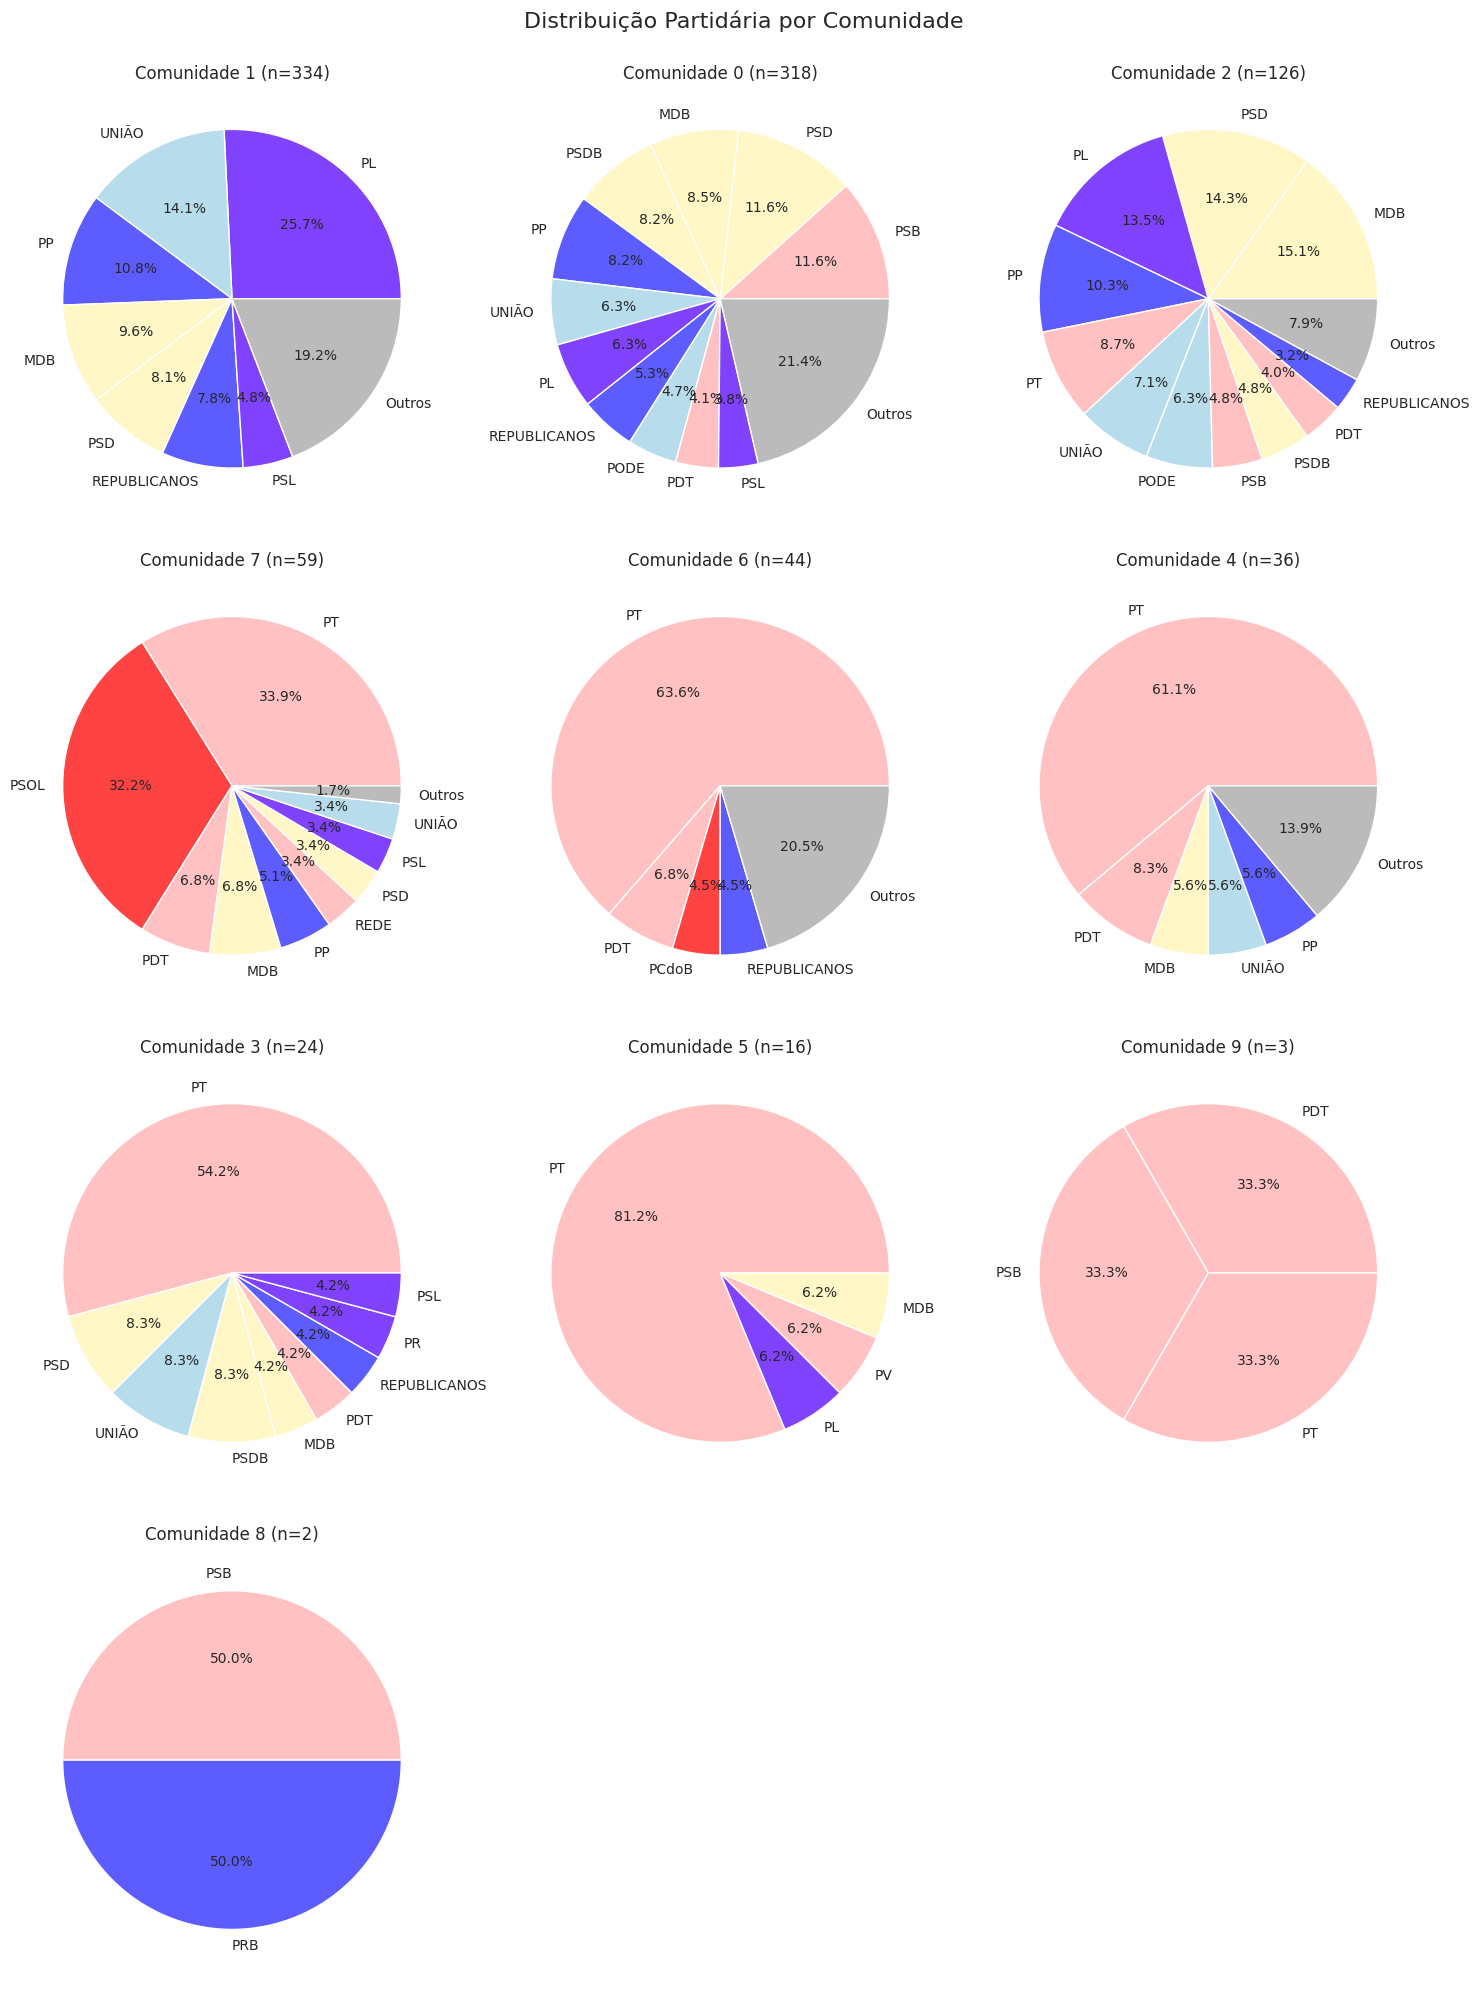

In [13]:
collab_node_no_ents_df = collab_node_df[collab_node_df['type'].ne('Orgao')]

ideol_by_party = (
    collab_node_no_ents_df[['cod_partido', 'ideol_partido']]
        .drop_duplicates()
        .set_index('cod_partido', drop=True)['ideol_partido']
        .to_dict()
)
comm_df = collab_node_no_ents_df.groupby('leiden_mod').agg(
    size=('leiden_mod', 'size'),
    author_type=('type', lambda x: x.value_counts().to_dict()),
    party=('cod_partido', lambda x: x.value_counts().to_dict()),
    ideology=('ideol_partido', lambda x: x.value_counts().to_dict()),
    region=('regiao', lambda x: x.value_counts().to_dict()),
    state=('uf', lambda x: x.value_counts().to_dict()),
).sort_values('size', ascending=False)[['size', 'party', 'ideology']]


ideology_colors = {
    'left': "#FF4343",
    'centre-left': "#FFC1C1",
    'centre': "#FFF7C6",
    'centre-right': "#B7DCEB",
    'right': "#5D5DFF",
    'far-right': "#8042FC"
}

# Create a figure with subplots for each community
n_communities = len(comm_df)
n_cols = 3  # Number of columns in subplot grid
n_rows = (n_communities + n_cols - 1) // n_cols  # Calculate needed rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_communities > 1 else [axes]

fig.suptitle('Distribuição Partidária por Comunidade', fontsize=16, y=0.995)

for idx, (comm_id, row) in enumerate(comm_df.iterrows()):
    party_dict = row['party']

    # Group parties that represent less than 5% of the community into "Outros"
    total_members = row['size'] or 1
    major_parties = []
    others_total = 0

    for party, count in sorted(party_dict.items(), key=lambda x: x[1], reverse=True):
        share = count / total_members
        if share < 0.03:
            others_total += count
        else:
            major_parties.append((party, count))

    if not major_parties and others_total:
        major_parties.append(('Outros', others_total))
        others_total = 0

    labels = [party for party, _ in major_parties]
    sizes = [count for _, count in major_parties]
    colors = [
        ideology_colors.get(ideol_by_party.get(party, ''), '#CCCCCC')
        if party != 'Outros' else '#BBBBBB'
        for party in labels
    ]

    if others_total > 0:
        labels.append('Outros')
        sizes.append(others_total)
        colors.append('#BBBBBB')

    ax = axes[idx]
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    ax.set_title(f'Comunidade {comm_id} (n={row["size"]})')

# Hide any unused subplots
for idx in range(n_communities, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### 4.2.2. Cálculo do índice de concentração

Vamos agora calcular a concentração de cada partido. Usaremos para isso o índice de Gini para valores discretos, com o coeificente final equivalendo a 1.0 se o partido está totalmente concentrado em uma única comunidade e próximo a 0.0 se cada membro está numa comunidade diferente.

**Cálculo**

Dado um partido com $N$ membros, distribuídos em uma ou mais de $K$ comunidades totais, sejam $s_1, s_2, \ldots, s_K$ o número de membros desse partido em cada comunidade, e portanto $\sum_{i=1}^{K}s_i = N$.

Calculamos então o índice Gini $G$ pela fórmula:

$$G = \frac{1}{2K}\sum_{i=1}^{K}\sum_{j=1}^{K}|s_i-s_j|$$

Normalizamos então, para que 1.0 corresponda a concentração total:

$$\widetilde{G} = \frac{G}{1 - \frac{1}{K}}$$

In [4]:
pivot_df = collab_node_no_ents_df.pivot_table(
    columns='leiden_mod',
    index='cod_partido',
    aggfunc='size',
    fill_value=0
)
pivot_df

leiden_mod,0,1,2,3,4,5,6,7,8,9
cod_partido,,,,,,,,,,
AVANTE,5,5,0,0,0,0,0,1,0,0
CIDADANIA,5,2,0,0,0,0,0,0,0,0
DEM,5,2,2,0,1,0,0,0,0,0
MDB,27,32,19,1,2,1,1,4,0,0
NOVO,9,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
REPUBLICANOS,17,26,4,1,1,0,2,0,0,0
SOLIDARIEDADE,7,3,0,0,0,0,0,0,0,0
Sem Partido,0,0,1,0,0,0,0,0,0,0


Vejamos como os maiores partidos se comportam. Quanto maior a área abaixo da diagonal, mais coeso o partido é (maior o Gini).

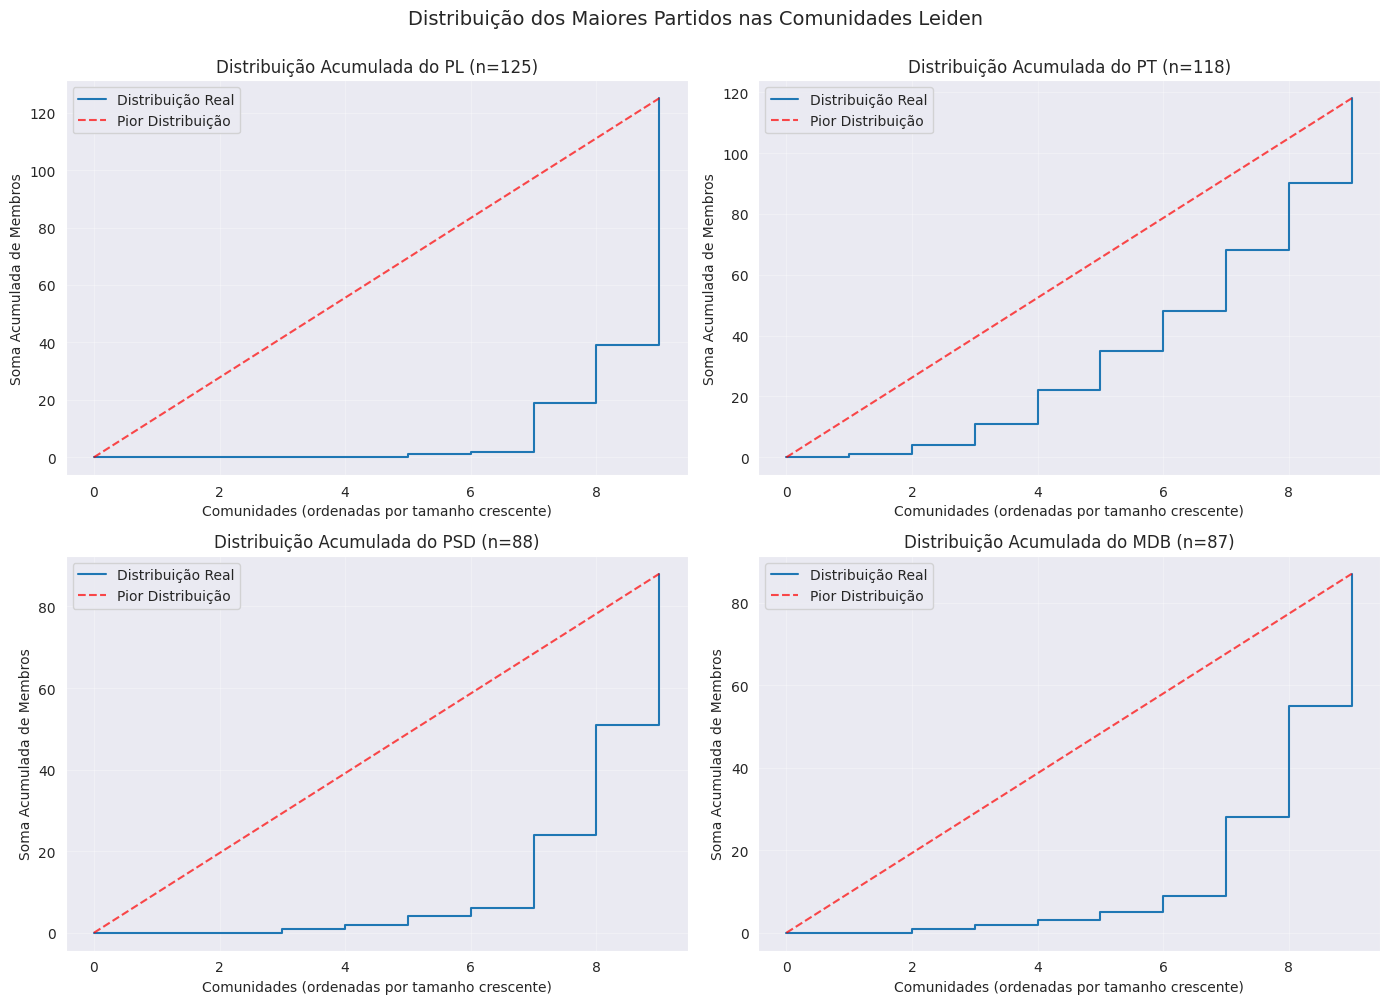

In [14]:
biggest_parties = collab_node_no_ents_df.value_counts('cod_partido', ascending=False)[:4]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (party_name, party_count) in enumerate(biggest_parties.items()):
    ax = axes[idx]
    
    party_sorted = pivot_df.loc[party_name, :].sort_values()
    party_cumsum = party_sorted.cumsum()
    
    ax.step(range(len(party_cumsum)), party_cumsum.values, where='post', label='Distribuição Real')
    ax.plot([0, len(party_cumsum) - 1], [0, party_cumsum.iloc[-1]], 
            linestyle='--', color='red', alpha=0.7, label='Pior Distribuição')
    ax.set_xlabel('Comunidades (ordenadas por tamanho crescente)')
    ax.set_ylabel('Soma Acumulada de Membros')
    ax.set_title(f'Distribuição Acumulada do {party_name} (n={party_count})')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Distribuição dos Maiores Partidos nas Comunidades Leiden', fontsize=14, y=1.0)
plt.tight_layout()
plt.show()

Vemos que o PL aparenta ser mais coeso em termos de sua distribuição em comunidades, enquanto o PT é mais difuso.

Vamos agora calcular os índices para todos os partidos.

In [6]:
pivot_normalized_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)
pivot_normalized_df

leiden_mod,0,1,2,3,4,5,6,7,8,9
cod_partido,,,,,,,,,,
AVANTE,0.454545,0.454545,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.0,0.0
CIDADANIA,0.714286,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
DEM,0.500000,0.200000,0.200000,0.000000,0.100000,0.000000,0.000000,0.000000,0.0,0.0
MDB,0.310345,0.367816,0.218391,0.011494,0.022989,0.011494,0.011494,0.045977,0.0,0.0
NOVO,0.900000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
REPUBLICANOS,0.333333,0.509804,0.078431,0.019608,0.019608,0.000000,0.039216,0.000000,0.0,0.0
SOLIDARIEDADE,0.700000,0.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
Sem Partido,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [7]:
gini_df = pd.DataFrame(pivot_normalized_df.apply(get_gini, axis=1), columns=["gini"])
gini_df

,gini
cod_partido,
AVANTE,0.859
CIDADANIA,0.937
DEM,0.800
MDB,0.737
NOVO,0.978
...,...
REPUBLICANOS,0.826
SOLIDARIEDADE,0.933
Sem Partido,1.000


Temos que levar em conta o tamanho dos partidos, entretanto.

In [8]:
gini_df = gini_df.join(collab_node_df.value_counts('cod_partido'))
gini_df.sort_values('gini', ascending=False)

,gini,count
cod_partido,,
PPS,1.000,1
PHS,1.000,2
UDN,1.000,2
PSOL,1.000,19
REDE,1.000,2
...,...,...
PSD,0.778,88
PV,0.778,6
MDB,0.737,87


Por óbvio, partidos com menos membros tendem a se fragmentar menos. Vamos considerar apenas aqueles com 10 membros ou mais:

In [15]:
gini_morethan10_df = gini_df[gini_df['count'].ge(10)].sort_values('gini', ascending=False)
gini_morethan10_df

,gini,count
cod_partido,,
PSOL,1.000,19
NOVO,0.978,10
SOLIDARIEDADE,0.933,10
PR,0.899,11
PSB,0.898,48
PL,0.892,125
PRB,0.867,10
AVANTE,0.859,11
PSDB,0.845,43


In [17]:
gini_morethan10_df.to_excel(ACCESS_DIR / "gini_morethan10_df.xlsx")